In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import viz
from regression import Regressor, PreProcessing, CrossValidation


sns.set(style='whitegrid')
sns.set_palette('muted')

In [3]:
df = pd.read_csv(
    "C:\\Users\\wince\\Google Drive\\DATA SCIENCE\\LEZIONI\\ML\\Polignano\\01.REGRESSION\\DataEx_LinRegression\\heart.arff.csv",
    delimiter=',')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.601449,0.826087,0.478261,134.398551,251.086957,0.159420,0.449275,139.101449,0.550725,1.585507,1.166667,1.166667,2.543478
1,52.496970,0.563636,1.375758,129.303030,242.230303,0.139394,0.593939,158.466667,0.139394,0.583030,1.593939,0.363636,2.121212


In [6]:
df.groupby('target').std()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,7.962082,0.380416,0.905920,18.729944,49.454614,0.367401,0.541321,22.598782,0.499232,1.300340,0.561324,1.043460,0.684762
1,9.550651,0.497444,0.952222,16.169613,53.552872,0.347412,0.504818,19.174276,0.347412,0.780683,0.593635,0.848894,0.465752


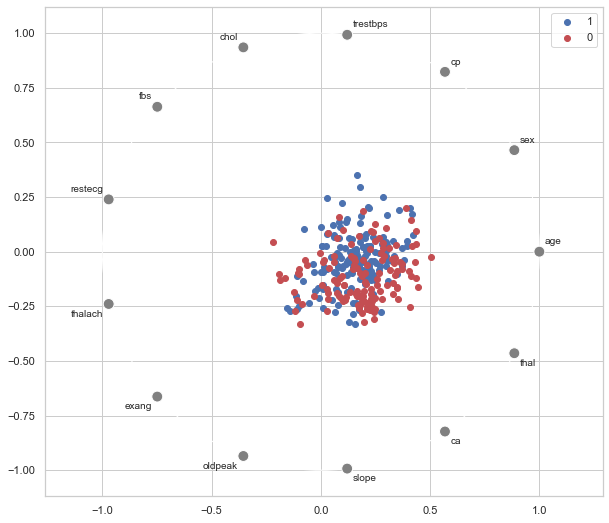

In [7]:
plt.figure(figsize=(10,9))
sns.despine()
pd.plotting.radviz(df, 'target', color=('b','r'));

In [8]:
cat_col = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
#cat_col = ['sex', 'fbs', 'exang', 'target']
df[cat_col] = df[cat_col].astype('category')
num_col = df.columns[df.dtypes != 'category']
num_col

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], dtype='object')

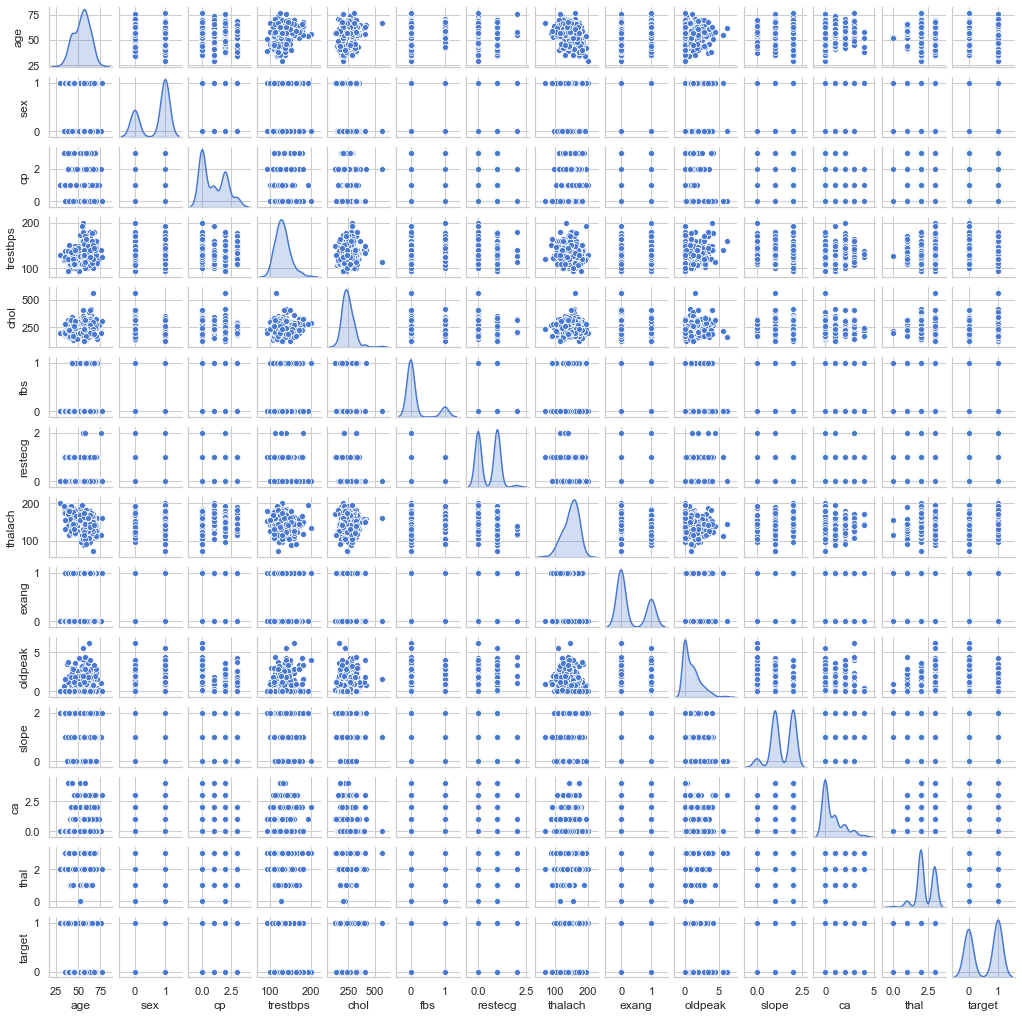

In [9]:
sns.pairplot(df, diag_kind='kde', height=1., kind='scatter');

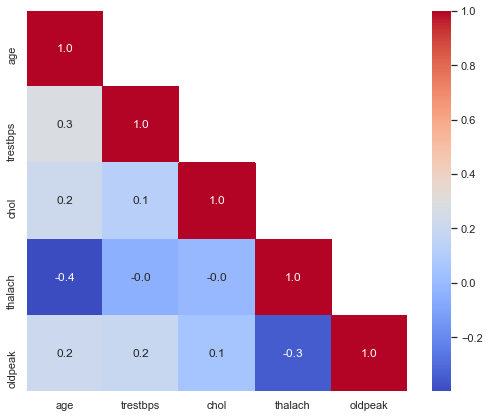

In [10]:
viz.corr_matrix(df)

In [11]:
df_mix = df.copy()

In [12]:
df_mix.describe(include='number')

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [13]:
df_mix.describe(include='category')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


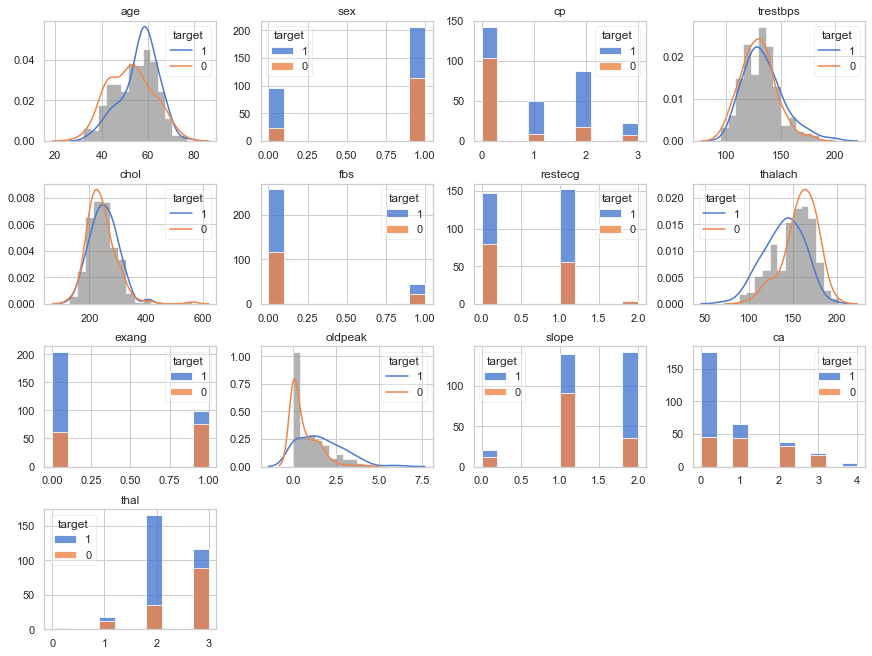

In [14]:
viz.hist(df_mix, ref='target', bins=15)

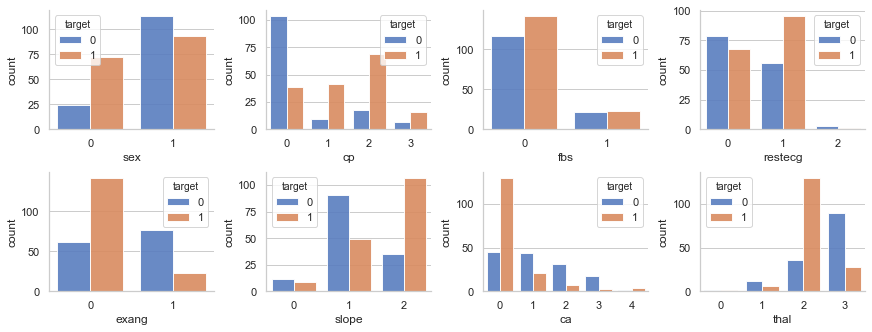

In [15]:
viz.var_vs_target(df_mix, kind='category', ref='target');

In [16]:
df_mix.pivot_table(index=['sex','ca'], values='target', columns=['cp'], aggfunc='count', margins=1)

cp          0     1     2     3  All
sex ca                              
0   0    24.0  11.0  26.0   3.0   64
    1     2.0   4.0   9.0   NaN   15
    2     9.0   3.0   NaN   1.0   13
    3     4.0   NaN   NaN   NaN    4
1   0    41.0  26.0  31.0  13.0  111
    1    32.0   4.0  11.0   3.0   50
    2    20.0   NaN   2.0   3.0   25
    3    10.0   1.0   5.0   NaN   16
    4     1.0   1.0   3.0   NaN    5
All     143.0  50.0  87.0  23.0  303

In [17]:
df_mix[num_col] = df_mix[num_col].transform(lambda x: np.log10(x+1e-7))

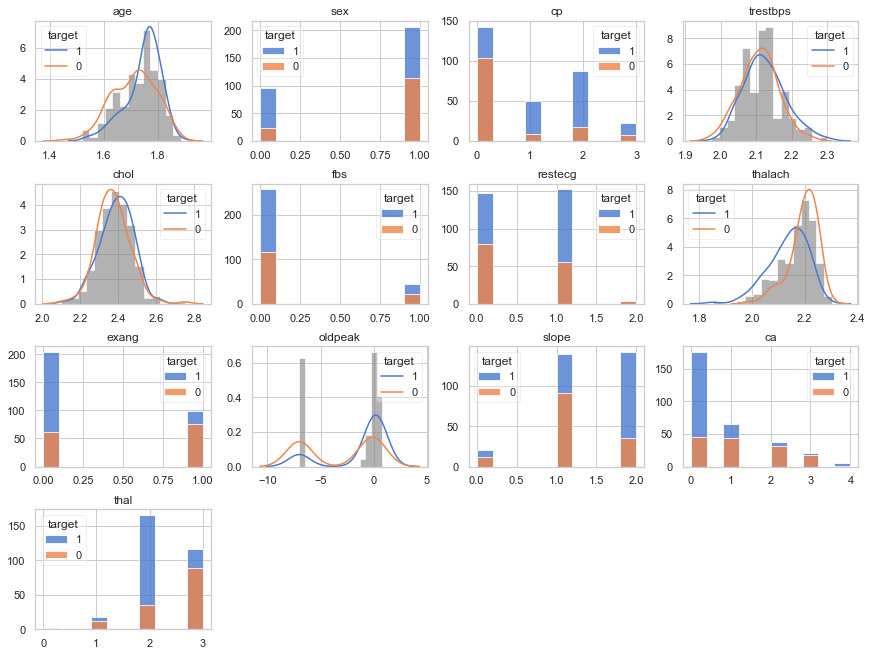

In [18]:
viz.hist(df_mix, ref='target', bins=15)

In [19]:
df_mix.groupby(df_mix['oldpeak'] > 0).oldpeak.count().to_frame()

,oldpeak
oldpeak,
False,166
True,137


In [20]:
df_mix.oldpeak = pd.qcut(df_mix.oldpeak, 3, labels=[1,2,3])

In [21]:
num_col = df_mix.columns[df_mix.dtypes != 'category']

In [22]:
pre = PreProcessing()

In [23]:
df_train, df_test = pre.split_train_test(df_mix, cutoff=.8, seed=5)

In [24]:
df_train = pre.fitnclip(df_train, kind='robust', columns=num_col)
df_test = pre.clip_outliers(df_test)

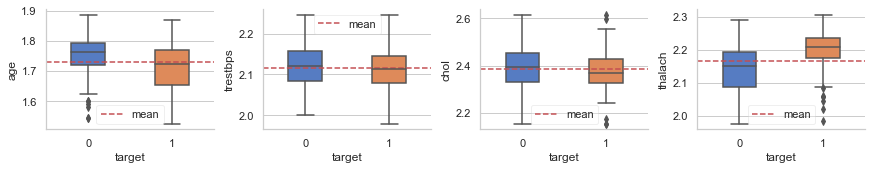

In [25]:
viz.var_vs_target(df_train, kind='number', ref='target')

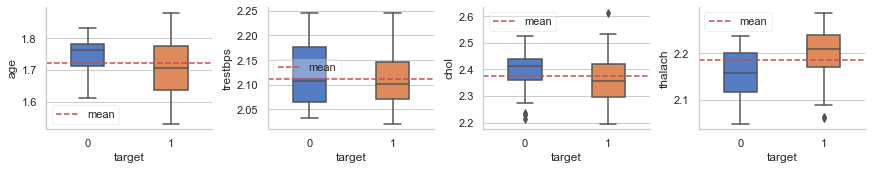

In [26]:
viz.var_vs_target(df_test, kind='number', ref='target')

In [27]:
df_train = pre.fitnscale(df_train, kind='standard', columns=num_col)
df_test = pre.scale(df_test)

In [28]:
df_train = pd.get_dummies(df_train, drop_first=True).sample(frac=1, random_state=3).reset_index(drop=True)
df_test = pd.get_dummies(df_test, drop_first=True).sample(frac=1, random_state=3).reset_index(drop=True)
df_train.head()

,age,trestbps,chol,thalach,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target_1
0,1.284398,-0.683002,-0.112909,-2.669173,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,-0.792119,-1.529619,0.016387,0.218952,1,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0.337689,-1.382176,-0.964954,-0.919794,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
3,0.234025,-0.039825,-0.474389,0.643069,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
4,0.128493,2.413665,1.551823,-1.369638,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [29]:
df_test.head()

,age,trestbps,chol,thalach,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target_1
0,-1.592021,-1.237390,0.163258,1.211448,1,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,1
1,-0.313743,-0.039825,1.191631,-0.194141,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
2,-0.918077,-1.755984,-0.888336,0.969303,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1
3,1.284398,-1.024987,2.735652,0.530308,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,0.539669,1.628646,0.618413,-0.968161,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


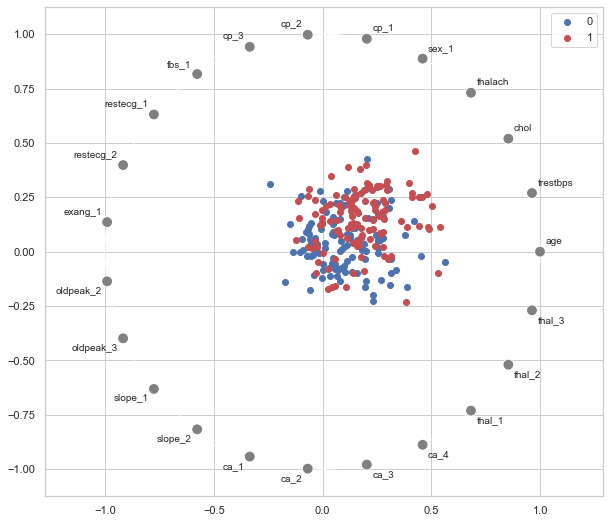

In [30]:
plt.figure(figsize=(10,9))
sns.despine()
pd.plotting.radviz(df_train, 'target_1', color=('b','r'));

In [31]:
log_reg = Regressor(l_rate=.4, reg_rate=5., beta=.1, stop=2e-4, epochs=1000, logistic=None)

In [32]:
log_reg.fitnpredict(df_train, df_test, target='target_1', reset=True);

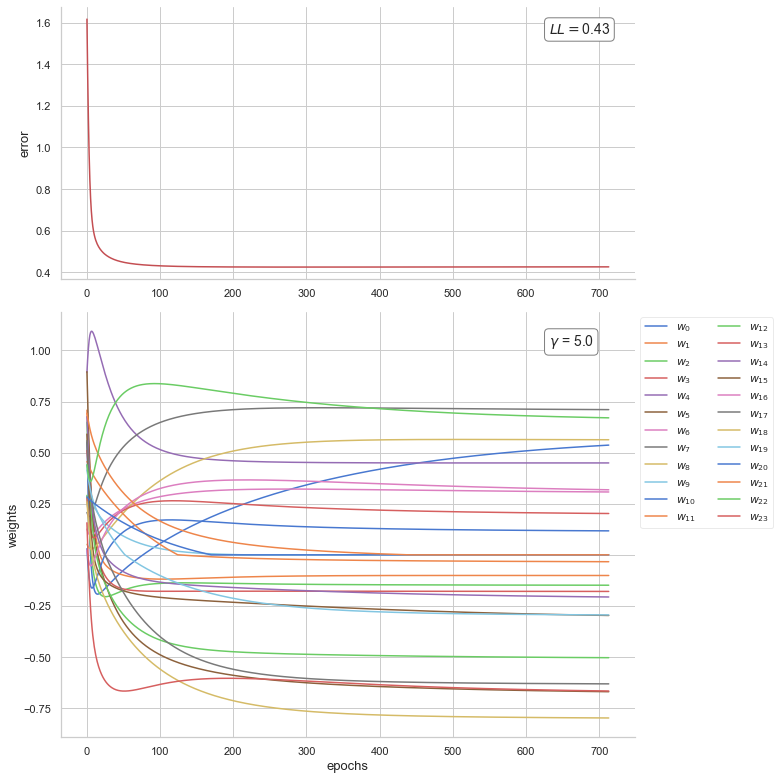

In [33]:
log_reg.graph()

In [34]:
log_reg.logistic

True

In [35]:
log_reg.parameters

,features,weights
0,bias,0.536959
1,age,-0.101033
2,trestbps,-0.148583
3,chol,-0.178989
4,thalach,0.449797
5,sex_1,-0.669638
6,cp_1,0.307664
7,cp_2,0.710622
8,cp_3,0.563254
9,fbs_1,0.000000


Accuracy: 0.869
Precision: 0.917
Recall: 0.868
F1 score: 0.892



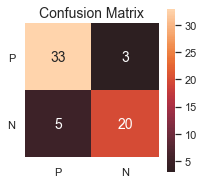

In [36]:
log_reg.metrics(threshold=.5)

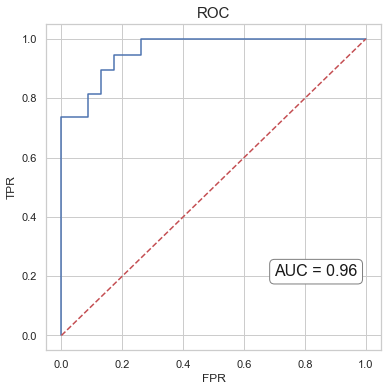

In [37]:
log_reg.ROC

In [38]:
CV = CrossValidation(model=log_reg, scaler=pre)

10-Folds Cross Validation

Accuracy: 0.837
Precision: 0.835
Recall: 0.871
F1 score: 0.853



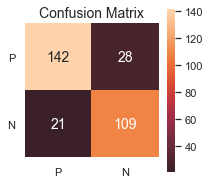

In [39]:
CV.metrics(df_mix, folds=10, seed=3)

Leave-one-out Cross Validation

Accuracy: 0.832
Precision: 0.839
Recall: 0.855
F1 score: 0.847



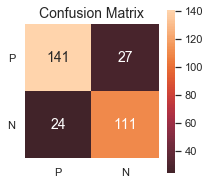

In [40]:
CV.metrics(df_mix, folds=len(df_mix), seed=3)